References & data: 
- https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification, 
- https://librosa.org/doc/main/index.html

In [497]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt, seaborn as sns

import librosa, librosa.display
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (10, 3)

In [498]:
features_30_sec = pd.read_csv('data/GTZAN_data/features_30_sec.csv')
features_3_sec = pd.read_csv('data/GTZAN_data/features_3_sec.csv')

data = features_30_sec

In [499]:
data.iloc[:,2:-1].describe()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,1.844345e+06,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,1.425085e+06,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,1.468612e+04,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,7.727312e+05,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,1.476115e+06,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,2.555262e+06,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,8.660900e+06,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


Let's have a look on those features given in csv data

Mean and Variance of
- Chromagram STFT
- RMS(root mean square) 
- Spectral Centroid
- Spectral Bandwidth
- Spectral Rolloff
- Zero Crossing Rate
- Harmony time series
- Perceptr(Percussive) time series
- Tempo (bmp)
- MFCC1 ~ 20

In [500]:
path_audio = "data/GTZAN_data/genres_original/classical/classical.00000.wav"
# path_audio = "data/GTZAN_data/genres_original/blues/blues.00000.wav"

In [501]:
features = features_30_sec[features_30_sec.filename==path_audio.split('/')[-1]]

# Understanding Features

Let's look at an example of a single audio wav file.

In [502]:
y, sr = librosa.load(path_audio)
#y = librosa.effects.trim(y)[0] # check if there is silence before or after the actual audio

In [503]:
ipd.Audio(y, rate=sr)

In [504]:
print(f"- wav information - \n audio time series: {len(y)} \n sample rate: {sr} \n audio length: {len(y)/sr}")

- wav information - 
 audio time series: 661794 
 sample rate: 22050 
 audio length: 30.013333333333332


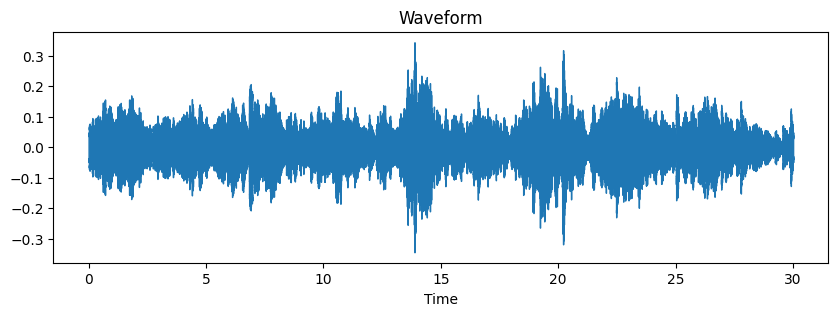

In [505]:
plt.title('Waveform')
librosa.display.waveshow(y=y,sr=sr)
plt.show()

Spectogram / Mel-spectogram

- log-frequency

In [506]:
# fft parameters
n_fft = 2048
hop_length = 512

# STFT
# The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.
D = librosa.stft(y=y, n_fft=2048, hop_length=hop_length, window='hann', center=True) #stft coefficient

# Amplitude
S, _ = librosa.magphase(D, power=1) # S = np.abs(D) energy
S_pw, _ = librosa.magphase(D, power=2) # S = np.abs(D)**2 power

In [507]:
print(S.shape)

(1025, 1293)


In [508]:
# Convert an amplitude spectrogram to dB-scaled spectrogram
S_dB = librosa.amplitude_to_db(S, ref=np.max)

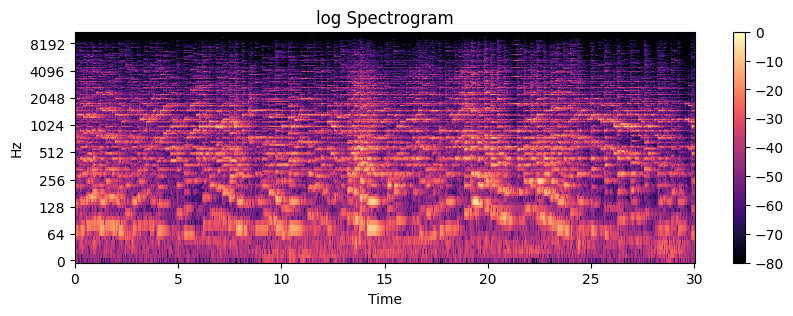

In [509]:
plt.title('log Spectrogram')
librosa.display.specshow(data=S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

The Mel spectrogram is a spectrogram with a Mel scale on the y axis.

In [510]:
mel_S = librosa.feature.melspectrogram(y=y, sr=sr)
# or (same output)
mel_S = librosa.feature.melspectrogram(S=S) 

mel_S_dB = librosa.amplitude_to_db(mel_S, ref=np.max)

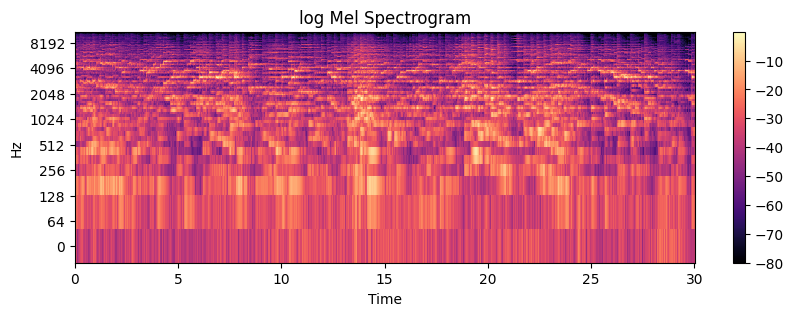

In [511]:
plt.title('log Mel Spectrogram')
librosa.display.specshow(mel_S_dB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log')
plt.colorbar()
plt.show()

## Musical Features

### Zero crossing rate

In [512]:
zero_crossings = librosa.zero_crossings(y=y, pad=False)
print(sum(zero_crossings))

65095


In [513]:
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
print(f"- Zero Crossing Rate -\n shape: {zero_crossing_rate.shape} \n mean: {np.mean(zero_crossing_rate)} \n variance: {np.std(zero_crossing_rate)**2}")

- Zero Crossing Rate -
 shape: (1, 1293) 
 mean: 0.0982227015661253 
 variance: 0.0004313937769114764


In [514]:
# check
print(features.zero_crossing_rate_mean.values, features.zero_crossing_rate_var.values)

[0.0982227] [0.00043139]


### Harmonics-Percussive Source Separation

In [515]:
y_harm, y_perc = librosa.effects.hpss(y=y)

# or (same output)
D_harm, D_perc = librosa.decompose.hpss(D)
y_harm = librosa.istft(D_harm)
y_perc = librosa.istft(D_perc)

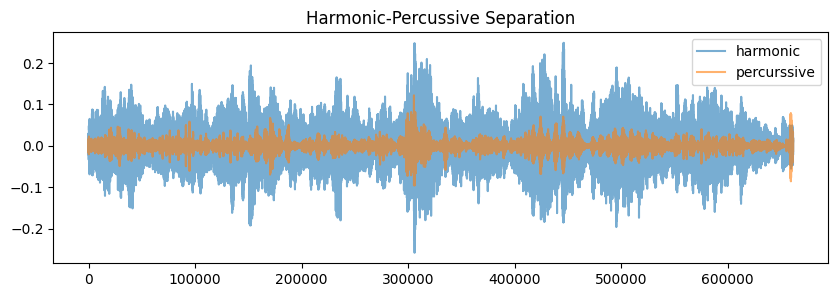

In [516]:
plt.title('Harmonic-Percussive Separation')
plt.plot(y_harm, alpha=.6)
plt.plot(y_perc, alpha=.6)
plt.legend(['harmonic','percurssive'])
plt.show()

In [517]:
print(f"- Harmonic y -\n shape: {y_harm.shape} \n mean: {np.mean(y_harm)} \n variance: {np.var(y_harm)}")
print()
print(f"- Percussive y -\n shape: {y_perc.shape} \n mean: {np.mean(y_perc)} \n variance: {np.var(y_perc)}")

- Harmonic y -
 shape: (661504,) 
 mean: -4.648520553018898e-05 
 variance: 0.0012301784008741379

- Percussive y -
 shape: (661504,) 
 mean: -0.00012128985690651461 
 variance: 6.028851930750534e-05


In [518]:
# check
print(features.harmony_mean.values, features.harmony_var.values)
print(features.perceptr_mean.values, features.perceptr_var.values)

[-4.66024067e-05] [0.00122963]
[-0.0001211] [6.0270424e-05]


not exactly same, but close

### BPM tempo

In [519]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, units='time')
print('BPM:', tempo)

BPM: 95.703125


In [520]:
print(features.tempo.values)

[95.703125]


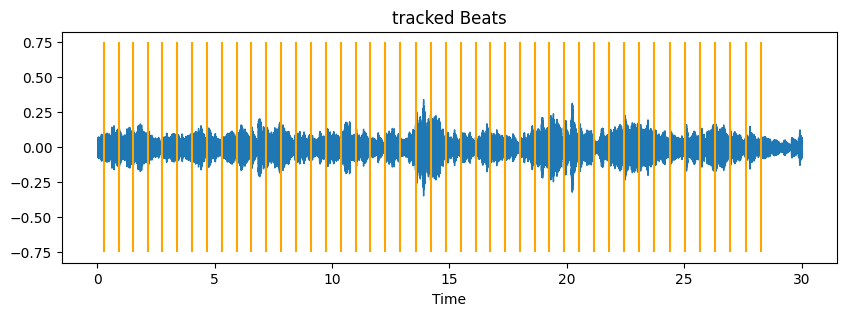

In [521]:
plt.title('tracked Beats')
librosa.display.waveshow(y=y,sr=sr)
plt.vlines(beats, ymin=-.75,ymax=.75, color='orange')
plt.show()

### Spectral centroids

In [522]:
# Calculate the Spectral Centroids
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
# or (same output)
centroid = librosa.feature.spectral_centroid(S=S)[0]

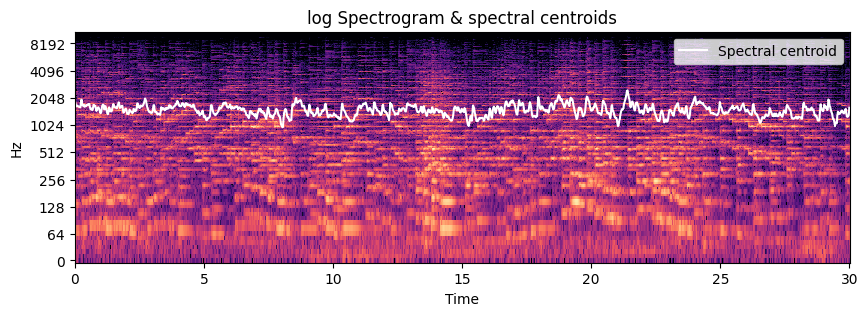

In [523]:
times = librosa.times_like(centroid)
fig, ax = plt.subplots()
librosa.display.specshow(S_dB, y_axis='log', x_axis='time', ax=ax)
ax.plot(times, centroid.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Spectrogram & spectral centroids')
plt.show()

In [524]:
print(f"- Spectral Centroids y -\n shape: {centroid.shape} \n mean: {np.mean(centroid)} \n variance: {np.var(centroid)}")

- Spectral Centroids y -
 shape: (1293,) 
 mean: 1505.3574607063904 
 variance: 44430.73283264563


In [525]:
print(features.spectral_centroid_mean.values, features.spectral_bandwidth_var.values)

[1505.16642397] [43682.97326723]


not exactly same but close

### spectral bandwith

In [526]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

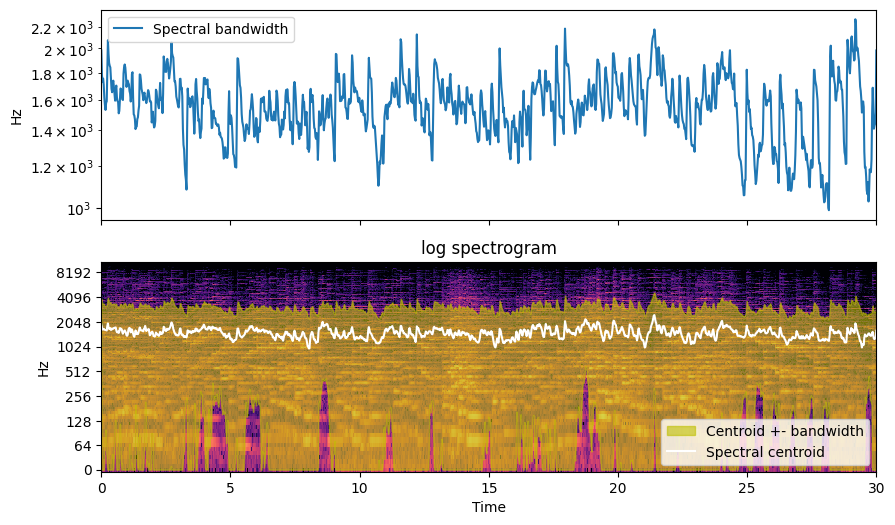

In [529]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,6))
times = librosa.times_like(spec_bw)
ax[0].semilogy(times, spec_bw, label='Spectral bandwidth') #log-scaled
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(S_dB, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log spectrogram')
ax[1].fill_between(times, np.maximum(0, centroid - spec_bw),
                np.minimum(centroid + spec_bw, sr/2),
                alpha=0.6, label='Centroid +- bandwidth', color='y')
ax[1].plot(times, centroid, label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')

In [530]:
print(f"- Spectral Bandwidth y -\n shape: {spec_bw.shape} \n mean: {np.mean(spec_bw)} \n variance: {np.var(spec_bw)}")

- Spectral Bandwidth y -
 shape: (1293,) 
 mean: 1559.2288947162588 
 variance: 43765.37312635112


In [531]:
print(features.spectral_bandwidth_mean.values, features.spectral_bandwidth_var.values)

[1559.00574034] [43682.97326723]


### Spectral roll off

In [532]:
# Spectral Roll-Off Vector
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]

[]

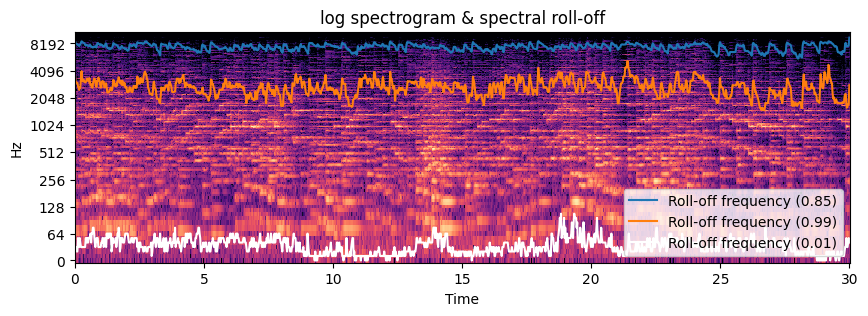

In [533]:
times = librosa.times_like(spectral_rolloff)

rolloff_max = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.99)
rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)

fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                          y_axis='log', x_axis='time', ax=ax)
ax.plot(times, rolloff_max[0], label='Roll-off frequency (0.85)')
ax.plot(times, spectral_rolloff, label='Roll-off frequency (0.99)')
ax.plot(times, rolloff_min[0], color='w', label='Roll-off frequency (0.01)')
ax.legend(loc='lower right')
ax.set(title='log spectrogram & spectral roll-off')
plt.plot()

In [534]:
print(f"- Spectral Roll-off y -\n shape: {spectral_rolloff.shape} \n mean: {np.mean(spectral_rolloff)} \n variance: {np.var(spectral_rolloff)}")

- Spectral Roll-off y -
 shape: (1293,) 
 mean: 2717.238763866734 
 variance: 299014.0000693897


In [535]:
print(features.rolloff_mean.values, features.rolloff_var.values)

[2716.30615801] [299398.30722597]


### MFCC (Mel-Frequency Cepstral Coefficients)

In [536]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
print('mfccs shape:', mfccs.shape)

mfccs shape: (20, 1293)


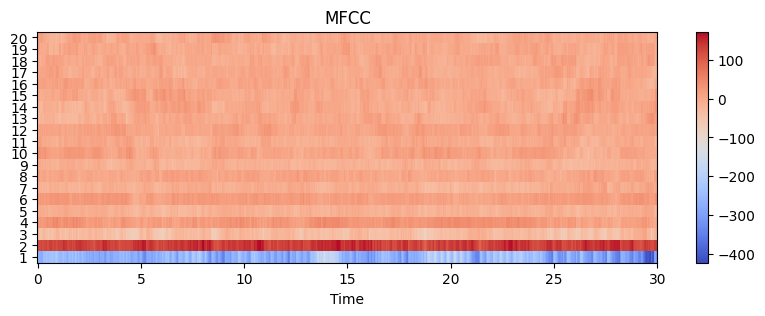

In [537]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')
ax.set_yticks(range(0,20), labels=range(1,21))
plt.show()

In [538]:
for i in range(20):
    print(f"MFCC {i+1} \n mean: {mfccs[i].mean()}, variance: {mfccs[i].var()}")
    print()

MFCC 1 
 mean: -268.21856689453125, variance: 1791.935791015625

MFCC 2 
 mean: 135.68165588378906, variance: 188.9014129638672

MFCC 3 
 mean: -34.05637741088867, variance: 231.39031982421875

MFCC 4 
 mean: 25.616008758544922, variance: 169.41429138183594

MFCC 5 
 mean: -12.971722602844238, variance: 71.249267578125

MFCC 6 
 mean: 17.903263092041016, variance: 74.56208801269531

MFCC 7 
 mean: -9.990859985351562, variance: 114.86932373046875

MFCC 8 
 mean: 5.634088039398193, variance: 65.84175872802734

MFCC 9 
 mean: -14.143672943115234, variance: 75.42843627929688

MFCC 10 
 mean: 7.493185043334961, variance: 177.2174530029297

MFCC 11 
 mean: -3.9764394760131836, variance: 106.70967102050781

MFCC 12 
 mean: 8.258308410644531, variance: 80.11543273925781

MFCC 13 
 mean: -1.3336011171340942, variance: 154.7423095703125

MFCC 14 
 mean: -0.35799506306648254, variance: 188.39491271972656

MFCC 15 
 mean: 1.0361007452011108, variance: 171.72482299804688

MFCC 16 
 mean: 3.79682254

In [539]:
features.iloc[:,19:-1].T

,100
mfcc1_mean,-268.195526
mfcc1_var,1792.286011
mfcc2_mean,135.691971
mfcc2_var,189.090881
mfcc3_mean,-34.051403
mfcc3_var,231.440308
mfcc4_mean,25.615507
mfcc4_var,169.200241
mfcc5_mean,-12.977585
mfcc5_var,71.468498


pretty much same

## Chroma stft

In [540]:
# Chromogram
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=1024)
# or (same output)
chromagram = librosa.feature.chroma_stft(S=S_pw, hop_length=1024) # Increase hop_length
print('Chromogram shape:', chromagram.shape)

Chromogram shape: (12, 1293)


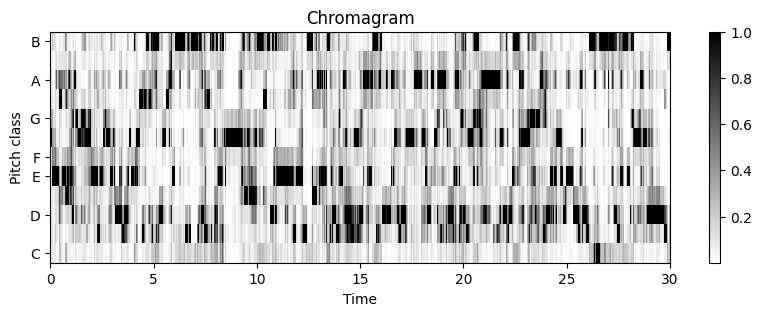

In [541]:
plt.title("Chromagram")
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time', cmap='gray_r')
plt.colorbar()
plt.show()

In [542]:
print(f"- Chroma STFT - \n mean: {chromagram.mean()}, variance: {chromagram.var()}")

- Chroma STFT - 
 mean: 0.25236058235168457, variance: 0.08414862304925919


In [543]:
print(features.chroma_stft_mean.values, features.chroma_stft_var.values)

[0.25239193] [0.08415318]


### RMS

root-mean-square (RMS) value for each frame

In [544]:
rms = librosa.feature.rms(y=y)
# or (same output)
rms = librosa.feature.rms(S=librosa.stft(y, window=np.ones, center=False))

Text(0.5, 0, 'Time')

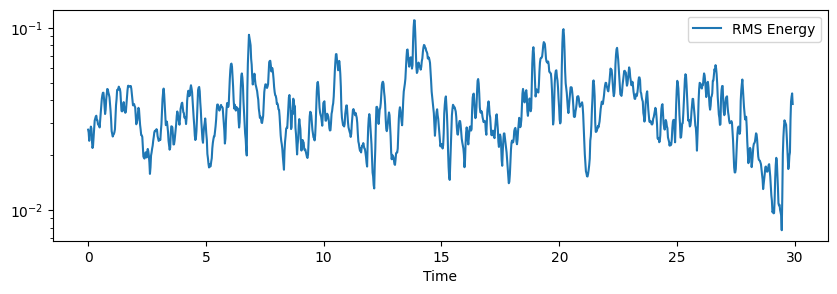

In [545]:
fig, ax = plt.subplots()
times = librosa.times_like(rms)
ax.semilogy(times, rms[0], label='RMS Energy') # log scaled
ax.legend()
ax.set_xlabel('Time')

In [546]:
print(f"- RMS - \n mean: {rms.mean()}, variance: {rms.var()}")

- RMS - 
 mean: 0.03627101697429944, variance: 0.00022120456304595005


In [547]:
print(features.rms_mean.values, features.rms_var.values)

[0.03624489] [0.00022075]
